In [1]:
import pandas as pd
import json
import warnings
warnings.filterwarnings('ignore')

In [2]:
def tranform_json_to_df(file_path, class_label):
    f = open(file_path)
    raw_json = json.load(f)
    f.close()
    esp32_data = raw_json['realtime']['esp32']
    df = pd.json_normalize(esp32_data)
    df.rename(columns={
        'accelerometer.x': 'AccX',
        'accelerometer.y': 'AccY',
        'accelerometer.z': 'AccZ',
        'gyro.x': 'GyroX',
        'gyro.y': 'GyroY',
        'gyro.z': 'GyroZ'
    }, inplace=True)
    df.drop(columns=['temperature'], inplace=True)
    df["Class"] = class_label
    return df

In [3]:
df_train_negative = tranform_json_to_df('data/esp32-training-negative.json', 0)
df_train_negative.head()

,AccX,AccY,AccZ,GyroX,GyroY,GyroZ,Class
0,0.98641,0.07901,8.33422,-0.03704,-0.00373,0.02851,0
1,0.99359,0.03112,8.33422,-0.03864,-0.00533,0.02825,0
2,1.00078,0.08140,8.32703,-0.03651,-0.00320,0.02984,0
3,1.03908,0.06943,8.33422,-0.03837,-0.00453,0.02745,0
4,0.99120,0.07901,8.31746,-0.03730,-0.00426,0.02798,0


In [5]:
df_train_positive = tranform_json_to_df('data/esp32-training-positive.json', 1)
df_train_positive.head()

,AccX,AccY,AccZ,GyroX,GyroY,GyroZ,Class
0,-3.31597,2.94966,4.92727,0.55371,-1.99607,0.10259,1
1,-3.28963,0.80206,6.75165,0.64750,-1.26463,0.58302,1
2,0.06943,1.04387,8.81545,-0.25234,-1.21560,0.07328,1
3,1.32639,1.25696,8.42520,0.64244,-0.82737,0.18040,1
4,3.76129,1.95846,6.19619,-0.47910,-1.26730,-0.68561,1


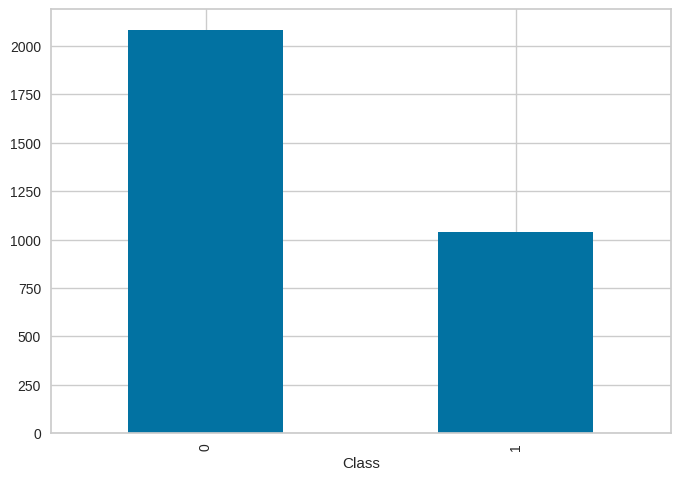

In [12]:
df_train = pd.concat([df_train_positive, df_train_negative], ignore_index=True)
df_train.groupby('Class')['Class'].count().plot.bar()

from sklearn.utils import shuffle
df_train = shuffle(df_train, random_state=42)

In [9]:
from pycaret.classification import *
exp_class= setup(df_train, target = 'Class',session_id=1)

,Description,Value
0,Session id,1
1,Target,Class
2,Target type,Binary
3,Original data shape,"(3126, 7)"
4,Transformed data shape,"(3126, 7)"
5,Transformed train set shape,"(2188, 7)"
6,Transformed test set shape,"(938, 7)"
7,Numeric features,6
8,Rows with missing values,1.0%
9,Preprocess,True


In [10]:
best_model = compare_models(errors="raise", exclude="lightgbm")

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
et,Extra Trees Classifier,0.9954,0.9999,0.9877,0.9986,0.9931,0.9897,0.9897,0.0600
gbc,Gradient Boosting Classifier,0.9950,0.9999,0.9877,0.9972,0.9924,0.9886,0.9887,0.1250
ada,Ada Boost Classifier,0.9945,0.9999,0.9890,0.9945,0.9917,0.9876,0.9877,0.0510
rf,Random Forest Classifier,0.9936,0.9998,0.9890,0.9918,0.9904,0.9856,0.9856,0.0880
knn,K Neighbors Classifier,0.9881,0.9909,0.9644,1.0000,0.9818,0.9730,0.9734,0.0180
nb,Naive Bayes,0.9877,0.9969,0.9890,0.9744,0.9816,0.9723,0.9724,0.0100
qda,Quadratic Discriminant Analysis,0.9872,0.9990,0.9890,0.9731,0.9810,0.9713,0.9714,0.0100
dt,Decision Tree Classifier,0.9863,0.9875,0.9698,0.9890,0.9792,0.9690,0.9692,0.0110
lr,Logistic Regression,0.7089,0.5832,0.1262,1.0000,0.2233,0.1613,0.2951,0.2790
lda,Linear Discriminant Analysis,0.7057,0.5851,0.1166,1.0000,0.2081,0.1495,0.2831,0.0090


In [11]:
model = create_model(best_model)
final_model = finalize_model(model)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9909,1.0000,0.9726,1.0000,0.9861,0.9793,0.9795
1,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
2,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
3,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
4,0.9954,1.0000,0.9863,1.0000,0.9931,0.9897,0.9897
5,0.9863,0.9997,0.9726,0.9861,0.9793,0.9691,0.9691
6,0.9954,1.0000,0.9863,1.0000,0.9931,0.9897,0.9897
7,0.9954,1.0000,0.9863,1.0000,0.9931,0.9897,0.9897
8,0.9908,0.9998,0.9726,1.0000,0.9861,0.9793,0.9795


In [13]:
# load test data
df_test_negative = tranform_json_to_df('data/esp32-test-negative.json', 0)
df_test_positive = tranform_json_to_df('data/esp32-test-positive.json', 1)
df_test = pd.concat([df_test_negative, df_test_positive], ignore_index=True)
df_test = shuffle(df_train, random_state=42)

In [14]:
unseen_predictions = predict_model(final_model, data=df_test)
unseen_predictions.tail(15)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Extra Trees Classifier,0.9971,1.0000,0.9914,1.0000,0.9957,0.9935,0.9935


,AccX,AccY,AccZ,GyroX,GyroY,GyroZ,Class,prediction_label,prediction_score
3023,1.04627,0.04070,8.341400,-0.03704,-0.00426,0.02851,0,0,1.0
240,5.78439,3.39737,7.546520,-0.98858,-0.29791,1.74959,1,1,1.0
1636,0.69671,0.43335,8.279150,-0.04104,-0.05782,0.04850,0,0,1.0
345,-5.85861,0.28970,5.858610,-1.89322,-2.85488,1.38747,1,1,1.0
3035,1.05345,0.04310,8.358160,-0.03730,-0.00373,0.02931,0,0,1.0
2263,1.54665,0.66080,8.425200,-0.06075,-0.02585,0.03757,0,0,1.0
269,0.74699,-11.22402,4.826710,1.84738,1.11541,-2.27346,1,1,1.0
2965,1.03908,0.02394,8.339000,-0.03677,-0.00426,0.02904,0,0,1.0
1471,1.01993,0.12689,8.350980,-0.03597,-0.00426,0.02851,0,0,1.0
2446,0.23463,-0.25618,8.401250,-0.00453,0.12657,0.12950,0,0,1.0


In [15]:
save_model(final_model, "driving-behavior-1")

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=None),
          steps=[('numerical_imputer',
                  TransformerWrapper(exclude=None,
                                     include=['AccX', 'AccY', 'AccZ', 'GyroX',
                                              'GyroY', 'GyroZ'],
                                     transformer=SimpleImputer(add_indicator=False,
                                                               copy=True,
                                                               fill_value=None,
                                                               keep_empty_features=False,
                                                               missing_values=nan,
                                                               strategy='mean'))),
                 ('categorical_imputer',
                  TransformerWrapper(exclude=None, includ...
                  ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0,
                                       class_weight=None, c